<a href="https://colab.research.google.com/github/HectorArielBaez/chatbot/blob/main/Copia_de_Copia_de_AST_TPFinal_ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neuralprophet
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 37.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from neuralprophet import NeuralProphet

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


In [ ]:
#esta función crea las columnas "ds" y "y". Además establece el indice como date
def ordenar(data):
  df = pd.DataFrame(data)

  # Paso 1: Transformar el DataFrame de formato ancho a formato largo
  df_long = df.melt(id_vars=['anio'], var_name='mes', value_name='y')

# Paso 2: Mapear los nombres de los meses a sus valores numéricos
  meses = {
    'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4, 'mayo': 5, 'junio': 6,
    'julio': 7, 'agosto': 8, 'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12
  }
  df_long['mes'] = df_long['mes'].map(meses)

# Paso 3: Crear la columna 'fecha' de tipo Date como una cadena con el día fijo en "01"
  df_long = df_long.dropna(subset=['mes'])  # Remove rows with NaN in 'mes'
  df_long['mes'] = df_long['mes'].astype(int) # Convert 'mes' to integers
  df_long['ds'] = pd.to_datetime(df_long['anio'].astype(str) + '-' + df_long['mes'].astype(str).str.zfill(2) + '-01')

  # Paso 4: Seleccionar solo las columnas 'fecha' y 'valor' y establecer 'fecha' como índice
  data = df_long.set_index('ds',drop=True)[['y']]
  data=data.dropna()
  data= data.sort_values(by='ds')
  data = data.reset_index()
  return data

In [ ]:
#Descompone la serie en las componentes y las grafica
def descomponer_serie_prophet(df, periods=365):
    """
    Descompone una serie temporal usando Prophet y extrae la tendencia y estacionalidad.

    Parámetros:
    - df: DataFrame que contiene la serie temporal con columnas 'ds' (fechas) y 'y' (valores).
    - periods: int, el número de periodos futuros para la predicción y descomposición (por defecto 365 días).

    Retorna:
    - Un DataFrame con las columnas originales, tendencia, estacionalidad y componente residual.
    """
    # Crear y ajustar el modelo
    modelo = Prophet(
        # Adding seasonality parameters
        weekly_seasonality=True,  # Enable weekly seasonality
        yearly_seasonality=True,  # Enable yearly seasonality
        daily_seasonality=False    # Disable daily seasonality (if not needed)
    )
    modelo.fit(df)

    # Crear un DataFrame para las fechas futuras
    futuro = modelo.make_future_dataframe(periods=periods)
    forecast = modelo.predict(futuro)

    # Extraer los componentes de tendencia y estacionalidad
    df['trend'] = forecast['trend'][:len(df)]
    df['seasonal'] = forecast['yearly'][:len(df)]
    df['residual'] = df['y'] - (df['trend'] + df['seasonal'])

    return df
def graficar_descomposicion(df):
    """
    Grafica la serie temporal original y sus descomposiciones de tendencia, estacionalidad y residual.

    Parámetros:
    - df: DataFrame que contiene las columnas 'ds' (fechas), 'y' (valores originales),
      'trend' (tendencia), 'seasonal' (estacionalidad) y 'residual' (residual).
    """
    plt.figure(figsize=(10, 12))

    # Serie original
    plt.subplot(4, 1, 1)
    plt.plot(df['ds'], df['y'], label='Serie Original')
    plt.title('Serie Temporal Original')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid (True)

    # Tendencia
    plt.subplot(4, 1, 2)
    plt.plot(df['ds'], df['trend'], label='Tendencia', color='orange')
    plt.title('Tendencia')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid (True)

    # Estacionalidad
    plt.subplot(4, 1, 3)
    plt.plot(df['ds'], df['seasonal'], label='Estacionalidad', color='green')
    plt.title('Estacionalidad')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid (True)

    # Residual
    plt.subplot(4, 1, 4)
    plt.plot(df['ds'], df['residual'], label='Residual', color='red')
    plt.title('Componente Residual')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()

    plt.tight_layout()
    plt.grid (True)
    plt.show()



In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_estacionariedad(df, column='y', signif_level=0.05):
    """
    Testea la estacionariedad de la serie temporal usando el test de Dickey-Fuller aumentado.

    Parámetros:
    - df: DataFrame que contiene la serie temporal.
    - column: Nombre de la columna de la serie temporal (por defecto 'y').
    - signif_level: Nivel de significancia para el test de Dickey-Fuller (por defecto 0.05).

    Retorna:
    - bool: True si la serie es estacionaria, False si no lo es.
    """
    # Extraer la serie temporal
    serie = df[column]

    # Aplicar el test de Dickey-Fuller
    resultado = adfuller(serie, autolag='AIC')

    # Extraer el valor p
    p_valor = resultado[1]

    # Imprimir resultado
    if p_valor <= signif_level:
        print(f"La serie es estacionaria. El p-valor es {p_valor:.5f}, menor o igual que el nivel de significancia de {signif_level}.")
        return True
    else:
        print(f"La serie NO es estacionaria. El p-valor es {p_valor:.5f}, mayor que el nivel de significancia de {signif_level}. Debe diferenciarse.")
        return False


In [ ]:
def hacer_estacionaria(df, column='y', signif_level=0.05, max_diff=None):
    """
    Hace que la serie temporal sea estacionaria utilizando transformaciones y
    verifica la estacionariedad con la prueba ADF.

    Args:
        df (pd.DataFrame): DataFrame con la serie temporal.
        column (str): Nombre de la columna con la serie temporal. Defaults to 'y'.
        signif_level (float): Nivel de significancia para la prueba ADF. Defaults to 0.05.
        max_diff (int, optional): Orden máximo de diferenciación. Defaults to None.

    Returns:
        pd.DataFrame: DataFrame con la serie temporal transformada y estacionaria.
    """

    serie_estacionaria_df = df.copy()
    serie_estacionaria = serie_estacionaria_df[column]

    # Verificar si la serie ya es estacionaria
    if test_estacionariedad(serie_estacionaria_df, column, signif_level):
        print("La serie ya es estacionaria.")
        return serie_estacionaria_df

    # Aplicar transformaciones hasta que sea estacionaria
    if max_diff is None:
        max_diff = len(serie_estacionaria) // 2  # Límite para evitar diferenciaciones excesivas

    for d in range(1, max_diff + 1):
        serie_diff = serie_estacionaria.diff(d).dropna()

        # Reindexar la serie después de la diferenciación
        serie_diff.index = serie_estacionaria_df.index[d:]

        # Crear un DataFrame temporal con los datos diferenciados
        serie_diff_df = pd.DataFrame({'ds': serie_estacionaria_df['ds'][d:], 'y': serie_diff.values})

        # Verificar la estacionariedad
        if test_estacionariedad(serie_diff_df, 'y', signif_level):
            print(f"Se logró la estacionariedad con {d} diferencia{'s' if d > 1 else ''}.")

            # Actualizar el DataFrame original con la serie diferenciada y la columna 'ds' actualizada
            serie_estacionaria_df = serie_diff_df

            # Realizar la descomposición con Prophet y graficar
            serie_descompuesta = descomponer_serie_prophet(serie_estacionaria_df)
            graficar_descomposicion(serie_descompuesta)
            return serie_estacionaria_df

    print("No se logró la estacionariedad con las transformaciones aplicadas.")
    return df  # Retornar el df original si no se logra estacionariedad



In [ ]:
def calcular_metricas(future_forecast):
    """
    Calcula el MAE y el RMSE entre las predicciones y los valores reales.

    Parámetros:
    - future_forecast: DataFrame de predicciones generadas por Prophet.
    - df_last_12: DataFrame con los últimos 12 valores reales.

    Retorna:
    - mae: Error absoluto medio entre las predicciones y los valores reales.
    - rmse: Raíz del error cuadrático medio entre las predicciones y los valores reales.
    """
    # Asegurarse de que ambas series tengan el mismo índice de fechas
    forecast_last_12 = future_forecast[['ds', 'yhat']].tail(12).reset_index(drop=True)
    real_values = data_futuro[['ds', 'y']].reset_index(drop=True)

    # Calcular MAE y RMSE
    mae = mean_absolute_error(real_values['y'], forecast_last_12['yhat'])
    rmse = np.sqrt(mean_squared_error(real_values['y'], forecast_last_12['yhat']))

    return mae, rmse
def calcular_metricas_neural(future_forecast):
    """
    Calcula el MAE y el RMSE entre las predicciones y los valores reales.

    Parámetros:
    - future_forecast: DataFrame de predicciones generadas por NeuralProphet.
    - data_futuro: DataFrame con los últimos 12 valores reales.

    Retorna:
    - mae: Error absoluto medio entre las predicciones y los valores reales.
    - rmse: Raíz del error cuadrático medio entre las predicciones y los valores reales.
    """
    # Asegurarse de que ambas series tengan el mismo índice de fechas
    forecast_last_12 = future_forecast[['ds', 'yhat1']].tail(12).reset_index(drop=True)
    real_values = data_futuro[['ds', 'y']].reset_index(drop=True)

    # Calcular MAE y RMSE
    mae = mean_absolute_error(real_values['y'], forecast_last_12['yhat1'])
    rmse = np.sqrt(mean_squared_error(real_values['y'], forecast_last_12['yhat1']))

    return mae, rmse

In [ ]:
def evaluar_modelo_prophet_con_graficos(df, train_size=0.8):
    """
    Entrena un modelo Prophet usando una parte de la serie temporal y evalúa las predicciones en la parte restante.
    También grafica las predicciones con sus bandas de error.

    Parámetros:
    - df: DataFrame que contiene la serie temporal con columnas 'ds' (fechas) y 'y' (valores).
    - train_size: Proporción de datos que se usarán para entrenamiento (por defecto 0.8).

    Retorna:
    - Métricas de error (MAE y RMSE) de las predicciones.
    """
    # Dividir los datos en entrenamiento y validación
    train_index = int(len(df) * train_size)
    df_train = df[:train_index]
    df_val = df[train_index:]

    # Crear y ajustar el modelo con los datos de entrenamiento
    modelo = Prophet()
    modelo.fit(df_train)

    # Generar predicciones para el periodo de validación
    future = modelo.make_future_dataframe(periods=len(df_val), freq='D')
    forecast = modelo.predict(future)

    # Extraer solo las predicciones correspondientes al conjunto de validación
    pred_val = forecast['yhat'][train_index:].values
    actual_val = df_val['y'].values

    # Calcular las métricas de error
    mae = mean_absolute_error(actual_val, pred_val)
    rmse = np.sqrt(mean_squared_error(actual_val, pred_val))

    # Imprimir las métricas de error
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Graficar la serie original, predicciones y bandas de error
    plt.figure(figsize=(14, 7))
    plt.plot(df['ds'], df['y'], label='Datos reales', color='blue')
    plt.plot(forecast['ds'], forecast['yhat'], label='Predicción', color='orange')
    plt.fill_between(forecast['ds'],
                     forecast['yhat_lower'],
                     forecast['yhat_upper'],
                     color='gray', alpha=0.3, label='Intervalo de confianza')

    # Delimitación del área de validación
    plt.axvline(x=df['ds'][train_index], color='black', linestyle='--', label='Inicio de validación')
    plt.legend()
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Predicciones con Prophet y Bandas de Error')
    plt.show()

    return mae, rmse


In [ ]:
def predecir_futuro_prophet(df, periodos_futuros):
    """
    Entrena un modelo Prophet con todos los datos y genera predicciones hacia el futuro,
    comparándolas con los valores reales de los últimos 12 periodos.

    Parámetros:
    - df: DataFrame que contiene la serie temporal con columnas 'ds' (fechas) y 'y' (valores).
    - periodos_futuros: Número de periodos en el futuro para los que se quiere predecir.
    - df_last_12: DataFrame que contiene los últimos 12 valores reales con las columnas 'ds' y 'y'.

    Retorna:
    - future_forecast: DataFrame de predicciones generadas por Prophet.
    """
    # Crear y ajustar el modelo Prophet con todos los datos
    modelo = Prophet()
    modelo.fit(df)

    # Crear un DataFrame para los periodos futuros y generar las predicciones
    future = modelo.make_future_dataframe(periods=periodos_futuros, freq='MS')
    forecast = modelo.predict(future)

    # Extraer solo el intervalo de predicción
    future_forecast = forecast[-periodos_futuros:]

    # Graficar la predicción junto con los valores reales de df_last_12
    plt.figure(figsize=(10, 5))
    plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Predicción', color='orange')
    plt.fill_between(future_forecast['ds'],
                     future_forecast['yhat_lower'],
                     future_forecast['yhat_upper'],
                     color='gray', alpha=0.3, label='Intervalo de confianza')

    # Agregar los valores reales de df_last_12
    plt.plot(data_futuro['ds'], data_futuro['y'], label='Valores Reales', color='blue', marker='o')

    plt.legend()
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title(f'Predicción a Futuro ({periodos_futuros} meses) con Prophet')
    plt.grid(True)
    plt.show()

    return future_forecast



In [ ]:
#Funciones para neural prophet
def evaluar_modelo_neuralprophet_con_graficos(df, train_size=0.8):
    """
    Entrena un modelo NeuralProphet usando una parte de la serie temporal y evalúa las predicciones en la parte restante.
    También grafica las predicciones con sus bandas de error.

    Parámetros:
    - df: DataFrame que contiene la serie temporal con columnas 'ds' (fechas) y 'y' (valores).
    - train_size: Proporción de datos que se usarán para entrenamiento (por defecto 0.8).

    Retorna:
    - Métricas de error (MAE y RMSE) de las predicciones.
    """
    # Crear una copia del DataFrame solo con columnas 'ds' y 'y'
    df = df[['ds', 'y']].copy()

    # Dividir los datos en entrenamiento y validación
    train_index = int(len(df) * train_size)
    df_train = df[:train_index]
    df_val = df[train_index:]

    # Crear y ajustar el modelo con los datos de entrenamiento
    modelo = NeuralProphet(quantiles=[0.05, 0.5, 0.95])  # Activa bandas de error
    modelo.fit(df_train, freq='MS')

    # Generar predicciones para el periodo de validación
    future = modelo.make_future_dataframe(df_train, periods=len(df_val), n_historic_predictions=True)
    forecast = modelo.predict(future)

    # Extraer solo las predicciones correspondientes al conjunto de validación
    pred_val = forecast['yhat1'][train_index:].values
    actual_val = df_val['y'].values

    # Calcular las métricas de error
    mae = mean_absolute_error(actual_val, pred_val)
    rmse = np.sqrt(mean_squared_error(actual_val, pred_val))

    # Imprimir las métricas de error
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Graficar la serie original, predicciones y bandas de error
    plt.figure(figsize=(14, 7))
    plt.plot(df['ds'], df['y'], label='Datos reales', color='blue')
    plt.plot(forecast['ds'], forecast['yhat1'], label='Predicción', color='orange')

    # Solo graficar las bandas de error si están presentes en los resultados
    if 'yhat1_lower' in forecast.columns and 'yhat1_upper' in forecast.columns:
        plt.fill_between(forecast['ds'],
                         forecast['yhat1_lower'],
                         forecast['yhat1_upper'],
                         color='gray', alpha=0.3, label='Intervalo de confianza')

    # Delimitación del área de validación
    plt.axvline(x=df['ds'][train_index], color='black', linestyle='--', label='Inicio de validación')
    plt.legend()
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Predicciones con NeuralProphet y Bandas de Error')
    plt.show()

    return mae, rmse

def predecir_futuro_neuralprophet(df, periodos_futuros):
    """
    Entrena un modelo NeuralProphet con todos los datos y genera predicciones hacia el futuro.

    Parámetros:
    - df: DataFrame que contiene la serie temporal con columnas 'ds' (fechas) y 'y' (valores).
    - periodos_futuros: Número de periodos en el futuro para los que se quiere predecir.

    Retorna:
    - future_forecast: DataFrame de predicciones generadas por NeuralProphet.
    """
    # Crear una copia del DataFrame solo con columnas 'ds' y 'y'
    df = df[['ds', 'y']].copy()

    # Crear y ajustar el modelo NeuralProphet con todos los datos
    modelo = NeuralProphet(quantiles=[0.05, 0.5, 0.95])
    modelo.fit(df, freq='MS')

    # Crear un DataFrame para los periodos futuros y generar las predicciones
    future = modelo.make_future_dataframe(df, periods=periodos_futuros)
    forecast = modelo.predict(future)

    # Graficar la predicción
    plt.figure(figsize=(10, 5))
    plt.plot(forecast['ds'], forecast['yhat1'], label='Predicción', color='orange')
    if 'yhat1_lower' in forecast.columns and 'yhat1_upper' in forecast.columns:
        plt.fill_between(forecast['ds'],
                         forecast['yhat1_lower'],
                         forecast['yhat1_upper'],
                         color='gray', alpha=0.3, label='Intervalo de confianza')
    plt.plot(data_futuro['ds'], data_futuro['y'], label='Valores Reales', color='blue', marker='o')
    plt.legend()
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title(f'Predicción a Futuro ({periodos_futuros} meses) con NeuralProphet')
    plt.grid(True)
    plt.show()

    return forecast[-periodos_futuros:]


In [ ]:
data_1=pd.read_excel("/content/girasol-serie-1969-2019-corto.xlsx", sheet_name="grano" )

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6_r_2wc/8yivv_7e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6_r_2wc/d4u1t5ov.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85282', 'data', 'file=/tmp/tmpx6_r_2wc/8yivv_7e.json', 'init=/tmp/tmpx6_r_2wc/d4u1t5ov.json', 'output', 'file=/tmp/tmpx6_r_2wc/prophet_modelbkdze8yq/prophet_model-20241126193055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:30:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:30:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds       y          trend       seasonal       residual
0 2000-01-01  340035  337102.156081  -58588.771554   61521.615473
1 2000-02-01  461190  336673.348174  -14537.226781  139053.878607
2 2000-03-01  778651  336272.205293  198666.532936  243712.261771
3 2000-04-01  575171  335843.397386   93358.761530  145968.841084
4 2000-05-01  431995  335428.421992  -15027.059445  111593.637453


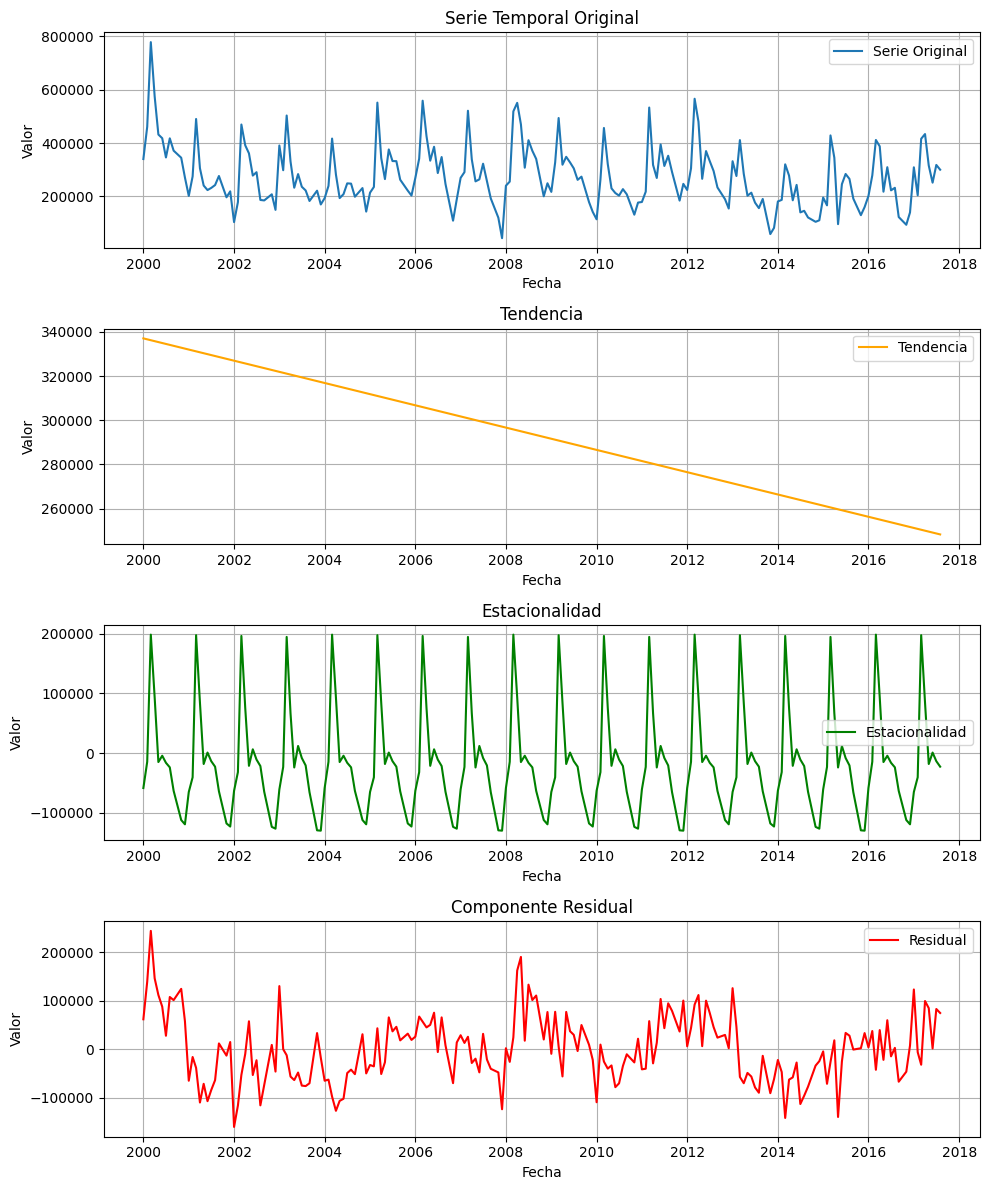

La serie es estacionaria. El p-valor es 0.01404, menor o igual que el nivel de significancia de 0.05.
La serie ya es estacionaria.


In [ ]:
#analisis inicial
data=data_1#agrego esto para tener el df original, sino, hay que leerlo cada vez
data=ordenar(data)
data_xgb=data
data_futuro = data.tail(12).reset_index(drop=True)  # Últimos 12 datos
data = data.iloc[:-12].reset_index(drop=True)
resultado = descomponer_serie_prophet(data)
print(resultado[['ds', 'y', 'trend', 'seasonal', 'residual']].head())
graficar_descomposicion(resultado)
#test_estacionariedad(data)
data=hacer_estacionaria(data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6_r_2wc/w4zdvmq1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6_r_2wc/tlp9yq04.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35773', 'data', 'file=/tmp/tmpx6_r_2wc/w4zdvmq1.json', 'init=/tmp/tmpx6_r_2wc/tlp9yq04.json', 'output', 'file=/tmp/tmpx6_r_2wc/prophet_modeltymhvb97/prophet_model-20241126193143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:31:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:31:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error (MAE): 141180.65
Root Mean Squared Error (RMSE): 172776.50


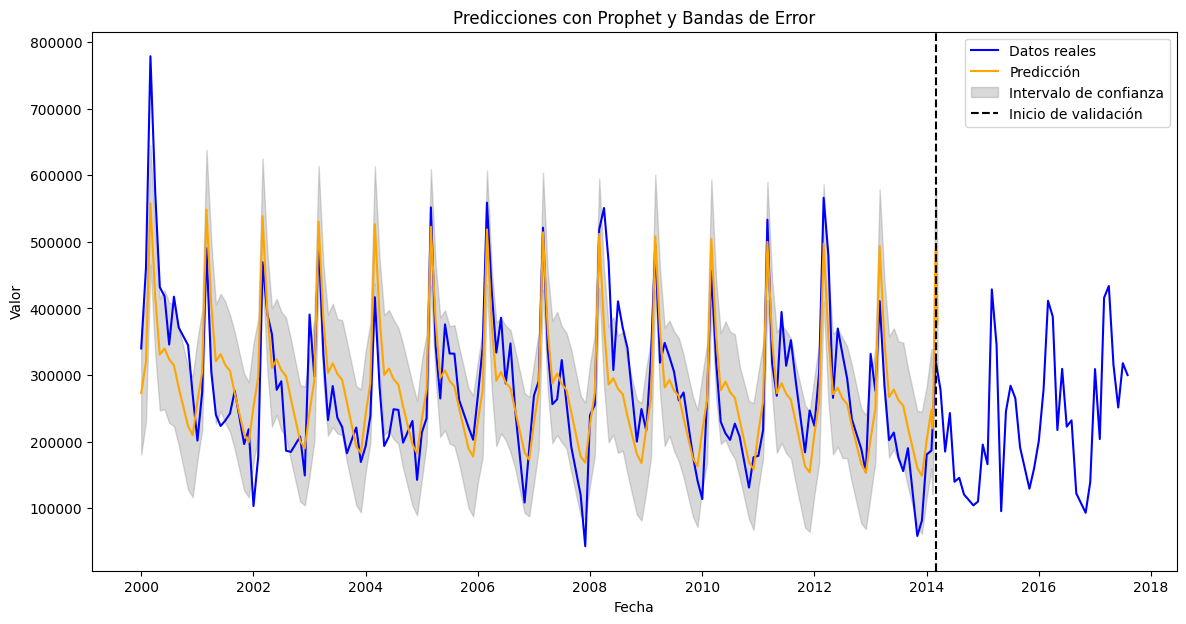

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6_r_2wc/_bz1d0q2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6_r_2wc/wtfddhqe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37838', 'data', 'file=/tmp/tmpx6_r_2wc/_bz1d0q2.json', 'init=/tmp/tmpx6_r_2wc/wtfddhqe.json', 'output', 'file=/tmp/tmpx6_r_2wc/prophet_model_rv43viz/prophet_model-20241126193144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:31:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:31:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


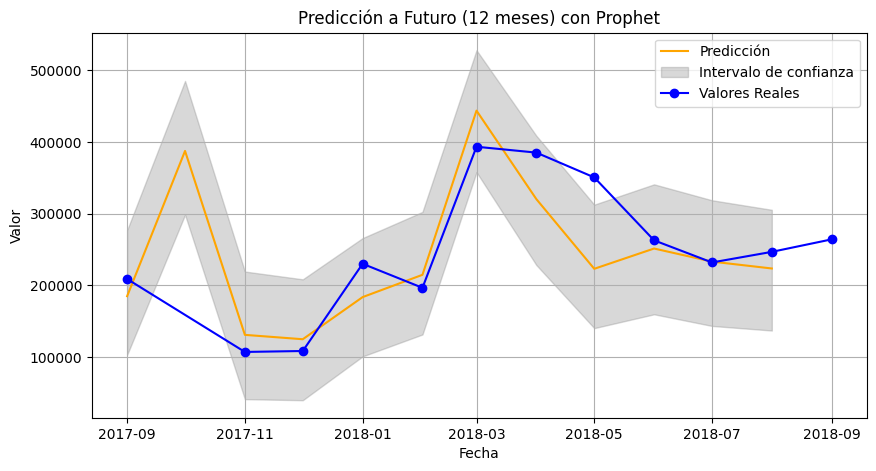

In [ ]:

#pipe para prophet
mae, rmse = evaluar_modelo_prophet_con_graficos(data)
forecast = predecir_futuro_prophet(data, periodos_futuros=12)

In [ ]:

# Paso 1: Asegurar que `ds` esté en formato datetime
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Paso 2: Crear un nuevo DataFrame con las columnas necesarias
df_prophet = forecast[['ds', 'yhat']].rename(columns={'yhat': 'y'})

# Verificar el resultado



In [ ]:
# Llamada a la función para calcular MAE y RMSE
mae, rmse = calcular_metricas(forecast)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 68847.22955674761
RMSE: 104508.16319271235


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [90.385]% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to [90.385]% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (10) is too small than the required number                     for the learning rate finder (210). The results might not be optimal.


Finding best initial lr:   0%|          | 0/210 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 12. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [90.385]% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to [90.385]% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/loc

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


Mean Absolute Error (MAE): 101124.03
Root Mean Squared Error (RMSE): 129029.36


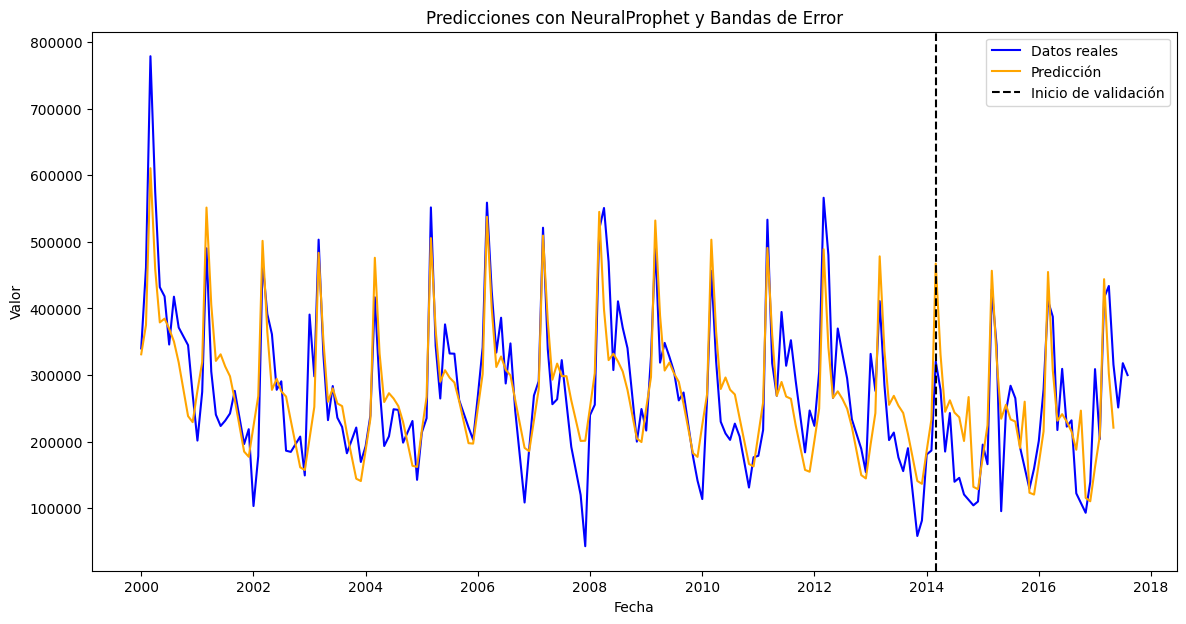

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [90.769]% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to [90.769]% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number                     for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [90.769]% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to [90.769]% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/loc

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


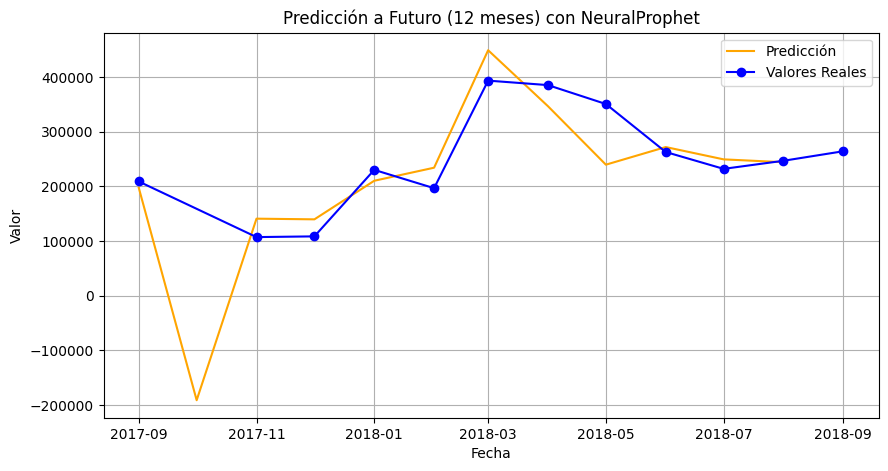

In [ ]:

mae, rmse = evaluar_modelo_neuralprophet_con_graficos(data)
forecast_neural = predecir_futuro_neuralprophet(df=data, periodos_futuros=12)

In [ ]:
# Llamada a la función para calcular MAE y RMSE
mae, rmse = calcular_metricas_neural(forecast_neural)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 63289.610677083336
RMSE: 104364.12627840214


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Crear características para XGBoost (lag features)
def crear_caracteristicas_lag(data, lags=12):
    """
    Agrega características lag a la serie temporal.

    Parámetros:
    - data: DataFrame con columnas 'ds' y 'y'.
    - lags: Número de lags a crear.

    Retorna:
    - DataFrame con características lag.
    """
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['y'].shift(lag)
    df = df.dropna().reset_index(drop=True)
    return df
def predecir_futuro_xgboost(modelo, datos, lags, periodos_futuros=12):
    """
    Predice valores futuros usando un modelo XGBoost y características lag.

    Parámetros:
    - modelo: Modelo XGBoost entrenado.
    - datos: DataFrame con los valores históricos de la serie temporal, incluyendo las características lag.
    - lags: Número de lags usados para el modelo.
    - periodos_futuros: Número de valores futuros a predecir.

    Retorna:
    - Lista con los valores predichos.
    """
    predicciones = []

    # Get the last 'lags' rows of the DataFrame 'datos', including 'y' and lag features
    # Make sure to use all the columns used during training (not just 'y' and lag features)

    # Get the columns used for training (excluding 'ds' and 'y')
    columnas_entrenamiento = X_train.columns.tolist()

    # Extract the last 'lags' rows from the DataFrame 'datos' with the training columns
    datos_actuales = datos[columnas_entrenamiento].iloc[-lags:].values.tolist()

    for _ in range(periodos_futuros):
        # Crear las características lag
        X_futuro = np.array(datos_actuales[-1]).reshape(1, -1) # Use all features used during training

        # Predecir el siguiente valor
        prediccion = modelo.predict(X_futuro)[0]
        predicciones.append(prediccion)

        # Update 'datos_actuales' for the next prediction
        # Shift existing lag features and append the new prediction
        datos_actuales.append([prediccion] + datos_actuales[-1][1:-1] + [prediccion])

    return predicciones



In [ ]:
#crea mal el data frame porque no guarda el indice y porque tiene menos valores de los necesarios. Le faltan los ultimos 12
# Generar características lag
serie_lags = crear_caracteristicas_lag(data_xgb, lags=12)

# Dividir en conjuntos de entrenamiento y prueba
X = serie_lags.drop(columns=['ds', 'y'])
y = serie_lags['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert the columns to numeric type before training
X_train = X_train.astype(float)  # Change 'object' columns to float
X_test = X_test.astype(float)  # Convert X_test to numeric as well


# Entrenar modelo XGBoost
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
modelo_xgb.fit(X_train, y_train)


# Predecir en el conjunto de prueba
y_pred = modelo_xgb.predict(X_test)

resultados = X_test.copy()
resultados['Real'] = y_test.values
resultados['Predicción'] = y_pred
# Convert y_pred to a Pandas Series before applying tail
# Convert y_pred to a Pandas Series before applying tail and name the column 'y'
predicciones_xgb = pd.Series(y_pred, name='y').tail(12).reset_index(drop=True)
predicciones_xgb

,y
0,243528.046875
1,205983.015625
2,143727.937500
3,193411.734375
4,220506.265625
5,477638.843750
6,362126.718750
7,282391.937500
8,291122.375000
9,281793.437500


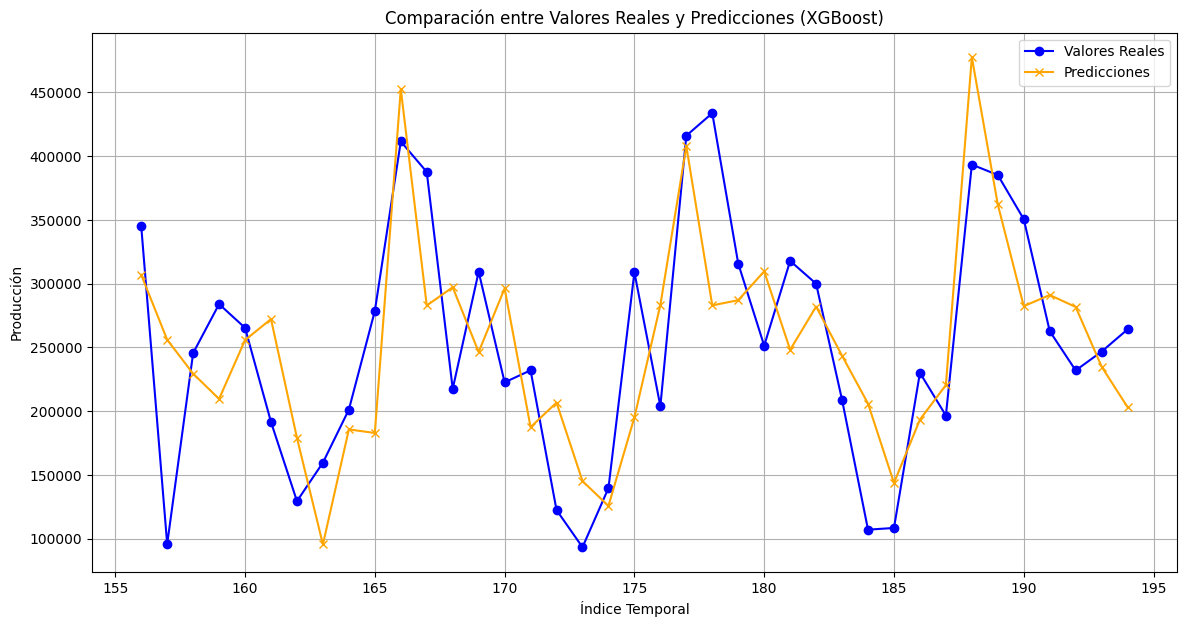

(57545.161658653844, 68121.94560700846)

In [ ]:


# Graficar
plt.figure(figsize=(14, 7))
plt.plot(resultados.index, resultados['Real'], label='Valores Reales', color='blue', marker='o')
plt.plot(resultados.index, resultados['Predicción'], label='Predicciones', color='orange', marker='x')
plt.xlabel('Índice Temporal')
plt.ylabel('Producción')
plt.title('Comparación entre Valores Reales y Predicciones (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()



# Calcular métricas de error
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae, rmse

In [ ]:
# Use serie_lags which contains all the lag features used during training
predicciones_futuras = predecir_futuro_xgboost(modelo_xgb, serie_lags, lags=12, periodos_futuros=12)

# Create a DataFrame for predictions
fechas_futuras = pd.date_range(start=data['ds'].iloc[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS')
predicciones_df = pd.DataFrame({'ds': fechas_futuras, 'y': predicciones_futuras})



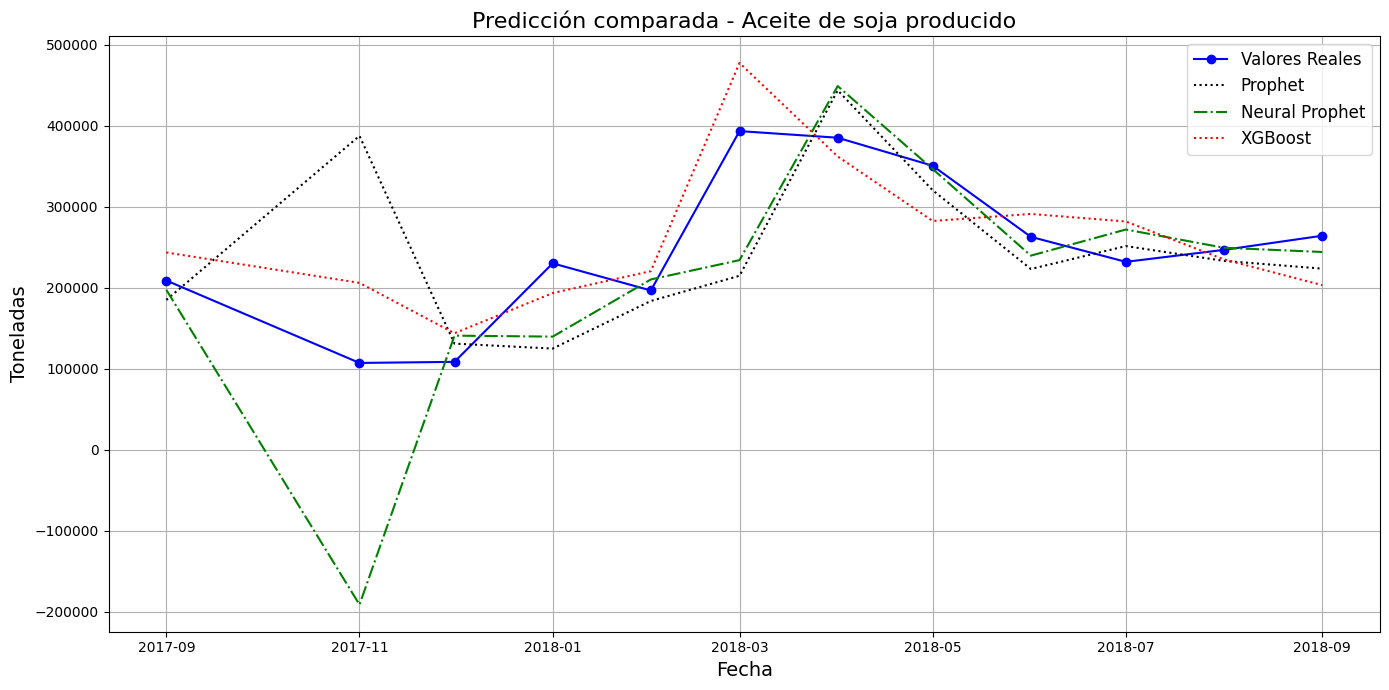

In [ ]:
df_prophet = df_prophet.reset_index(drop=True)
resultado_combinado = pd.DataFrame({
    'ds': data_futuro['ds'],        # Columna ds de data_futuro
    'valor real': data_futuro['y'],
    'Prophet':df_prophet['y'],
    'Neural Prophet': forecast_neural['yhat1'],
    'XGBoost': predicciones_xgb

    # Columna yhat1 de forecast_neural
}).set_index('ds')  # Establecer la columna ds como índice temporal

# Mostrar el DataFrame resultante
resultado_combinado.head()

# Graficar todas las series en el mismo gráfico
plt.figure(figsize=(14, 7))

# Graficar cada columna
plt.plot(resultado_combinado.index, resultado_combinado['valor real'], label='Valores Reales', color='blue', marker='o')
plt.plot(resultado_combinado.index, resultado_combinado['Prophet'], label='Prophet', color='black', linestyle=':')
plt.plot(resultado_combinado.index, resultado_combinado['Neural Prophet'], label='Neural Prophet', color='green', linestyle='-.')
plt.plot(resultado_combinado.index, resultado_combinado['XGBoost'], label='XGBoost', color='red', linestyle=':')

# Personalización del gráfico
plt.title('Predicción comparada - Aceite de soja producido', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Toneladas', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

